<a href="https://colab.research.google.com/github/rainardw/TUBES_PEMPAR/blob/main/TUGAS_BESAR_PEMPAR_KELOMPOK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Anggota Kelompok
group_members = {
    "ADITYA": "F1D02310",
    "DATU REKSA HAMZA PUTRA": "F1D02310",
    "KURNIA DWI SURYA": "F1D02310013"
}

# Link Dataset Kaggle
kaggle_link = "https://www.kaggle.com/datasets/yug201/disease-cancer-heart-liver"

print("ANGGOTA KELOMPOK 7:")
for name, nim in group_members.items():
    print(f"{name} - {nim}")

print("\nLink Dataset:", kaggle_link)


ANGGOTA KELOMPOK 7:
ADITYA - F1D02310
DATU REKSA HAMZA PUTRA - F1D02310
KURNIA DWI SURYA - F1D02310013

Link Dataset: https://www.kaggle.com/datasets/yug201/disease-cancer-heart-liver


In [52]:
from pyspark.sql.functions import lit
from pyspark.sql.types import StringType, IntegerType
from pyspark import SparkContext
from pyspark.sql import SparkSession
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing as mp
from pyspark.sql.functions import col, when, count
from pyspark.sql.functions import avg, round
from mpi4py import MPI

In [3]:
!pip install pyspark
sc = SparkContext.getOrCreate()
spark = SparkSession.builder.appName("DiseaseAnalysis").getOrCreate()

In [8]:
rdd_heart = sc.textFile("/content/heart.csv")
rdd_cancer = sc.textFile("/content/cancer patient data sets.csv")
rdd_liver = sc.textFile("/content/indian_liver_patient (1).csv")

header = rdd_heart.first()

data_heart = rdd_heart.filter(lambda row: row != header)
data_cancer = rdd_cancer.filter(lambda row: row != header)
data_liver = rdd_liver.filter(lambda row: row != header)

# Gabungkan semua data
data_all = data_heart.union(data_cancer).union(data_liver)

# Filter penyakit 'Heart Disease'
filtered_heart = data_all.filter(lambda row: "Heart Disease" in row)

# Tampilkan hasil
print("Contoh baris dengan Heart Disease:")
print(filtered_heart.take(5))

# Hitung jumlah kasus
heart_count = filtered_heart.count()
print(f"Jumlah kasus Heart Disease: {heart_count}")


Contoh baris dengan Heart Disease:
[]
Jumlah kasus Heart Disease: 0


In [6]:
# Buat SparkSession
spark = SparkSession.builder.appName("AnalisisPenyakit").getOrCreate()

# Baca CSV
df_heart = spark.read.csv("/content/heart.csv", header=True, inferSchema=True)
df_heart.show(5)
df_heart.printSchema()

df_cancer = spark.read.csv("/content/cancer patient data sets.csv", header=True, inferSchema=True)
df_cancer.show(5)
df_cancer.printSchema()

df_liver = spark.read.csv("/content/indian_liver_patient (1).csv", header=True, inferSchema=True)
df_liver.show(5)
df_liver.printSchema()

+---+---+-------------+---------+-----------+---------+----------+-----+--------------+-------+--------+------------+
|Age|Sex|ChestPainType|RestingBP|Cholesterol|FastingBS|RestingECG|MaxHR|ExerciseAngina|Oldpeak|ST_Slope|HeartDisease|
+---+---+-------------+---------+-----------+---------+----------+-----+--------------+-------+--------+------------+
| 40|  M|          ATA|      140|        289|        0|    Normal|  172|             N|    0.0|      Up|           0|
| 49|  F|          NAP|      160|        180|        0|    Normal|  156|             N|    1.0|    Flat|           1|
| 37|  M|          ATA|      130|        283|        0|        ST|   98|             N|    0.0|      Up|           0|
| 48|  F|          ASY|      138|        214|        0|    Normal|  108|             Y|    1.5|    Flat|           1|
| 54|  M|          NAP|      150|        195|        0|    Normal|  122|             N|    0.0|      Up|           0|
+---+---+-------------+---------+-----------+---------+-

In [10]:
def cek_null(df, nama_dataset):
    print(f"\nJumlah null pada dataset {nama_dataset}:")
    df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()

cek_null(df_heart, "Heart")
cek_null(df_cancer, "Cancer")
cek_null(df_liver, "Liver")


Jumlah null pada dataset Heart:
+---+---+-------------+---------+-----------+---------+----------+-----+--------------+-------+--------+------------+
|Age|Sex|ChestPainType|RestingBP|Cholesterol|FastingBS|RestingECG|MaxHR|ExerciseAngina|Oldpeak|ST_Slope|HeartDisease|
+---+---+-------------+---------+-----------+---------+----------+-----+--------------+-------+--------+------------+
|  0|  0|            0|        0|          0|        0|         0|    0|             0|      0|       0|           0|
+---+---+-------------+---------+-----------+---------+----------+-----+--------------+-------+--------+------------+


Jumlah null pada dataset Cancer:
+-----+----------+---+------+-------------+-----------+------------+--------------------+------------+--------------------+-------------+-------+-------+--------------+----------+-----------------+-------+-----------+-------------------+--------+---------------------+------------------------+-------------+---------+-------+-----+
|index|Pat

In [11]:
df_heart.groupBy("HeartDisease").count().show()
df_liver.groupBy("Dataset").count().show()
df_cancer.groupBy("Level").count().show()

+------------+-----+
|HeartDisease|count|
+------------+-----+
|           1|  508|
|           0|  410|
+------------+-----+

+-------+-----+
|Dataset|count|
+-------+-----+
|      1|  416|
|      2|  167|
+-------+-----+

+------+-----+
| Level|count|
+------+-----+
|  High|  365|
|   Low|  303|
|Medium|  332|
+------+-----+



In [15]:
df_heart = df_heart.toDF(*[c.strip().replace(" ", "_") for c in df_heart.columns])
print("\nStatistik Heart Dataset:")
df_heart.select(
    round(avg("Age"), 2).alias("Rata-rata_Usia"),
    round(avg("Cholesterol"), 2).alias("Rata-rata_Kolesterol"),
    round(avg("MaxHR"), 2).alias("Rata-rata_Detak_Jantung_Maks")
).show()



Statistik Heart Dataset:
+--------------+--------------------+----------------------------+
|Rata-rata_Usia|Rata-rata_Kolesterol|Rata-rata_Detak_Jantung_Maks|
+--------------+--------------------+----------------------------+
|         53.51|               198.8|                      136.81|
+--------------+--------------------+----------------------------+



In [18]:
print("\nPasien dengan kolesterol > 240 dan usia > 50:")
df_heart.filter((col("Cholesterol") > 240) & (col("Age") > 50)).show(5)


Pasien dengan kolesterol > 240 dan usia > 50:
+---+---+-------------+---------+-----------+---------+----------+-----+--------------+-------+--------+------------+
|Age|Sex|ChestPainType|RestingBP|Cholesterol|FastingBS|RestingECG|MaxHR|ExerciseAngina|Oldpeak|ST_Slope|HeartDisease|
+---+---+-------------+---------+-----------+---------+----------+-----+--------------+-------+--------+------------+
| 54|  F|          ATA|      120|        273|        0|    Normal|  150|             N|    1.5|    Flat|           0|
| 60|  M|          ASY|      100|        248|        0|    Normal|  125|             N|    1.0|    Flat|           1|
| 53|  M|          ASY|      124|        260|        0|        ST|  112|             Y|    3.0|    Flat|           0|
| 52|  M|          ATA|      120|        284|        0|    Normal|  118|             N|    0.0|      Up|           0|
| 53|  F|          ATA|      113|        468|        0|    Normal|  127|             N|    0.0|      Up|           0|
+---+---+

In [31]:
rdd_heart = df_heart.rdd

gender_count_heart = rdd_heart.map(lambda row: (row["Sex"], 1)).reduceByKey(lambda a, b: a + b)
df_gender_heart = gender_count_heart.toDF(["Sex", "Count"])
df_gender_heart.show()

+---+-----+
|Sex|Count|
+---+-----+
|  M|  725|
|  F|  193|
+---+-----+



In [33]:
rdd_liver = df_liver.rdd

gender_count_liver = rdd_liver.map(lambda row: (row["Gender"], 1)).reduceByKey(lambda a, b: a + b)
df_gender_liver = gender_count_liver.toDF(["Gender", "Count"])
df_gender_liver.show()

+------+-----+
|Gender|Count|
+------+-----+
|Female|  142|
|  Male|  441|
+------+-----+



In [27]:
rdd = df_cancer.rdd

gender_count = rdd.map(lambda row: (row["Gender"], 1)).reduceByKey(lambda a, b: a + b)
df_gender = gender_count.toDF(["Gender", "Count"])
df_gender.show()

+------+-----+
|Gender|Count|
+------+-----+
|     1|  598|
|     2|  402|
+------+-----+



In [25]:
df_heart.createOrReplaceTempView("data_penyakit")

spark.sql("SELECT Sex, COUNT(*) as Jumlah FROM data_penyakit GROUP BY Sex").show()

+---+------+
|Sex|Jumlah|
+---+------+
|  F|   193|
|  M|   725|
+---+------+



In [34]:
print("\nStatistik Cancer Dataset:")
df_cancer.select(
    round(avg("Age"), 2).alias("Rata-rata Usia"),
    round(avg("Genetic Risk"), 2).alias("Rata-rata Risiko Genetik")
).show()


Statistik Cancer Dataset:
+--------------+------------------------+
|Rata-rata Usia|Rata-rata Risiko Genetik|
+--------------+------------------------+
|         37.17|                    4.58|
+--------------+------------------------+



In [35]:
print("\nFiltering pasien dengan risiko genetik > 0 dan usia > 50:")
df_cancer.filter((col("Genetic Risk") > 0) & (col("Age") > 50)).show(5)


Filtering pasien dengan risiko genetik > 0 dan usia > 50:
+-----+----------+---+------+-------------+-----------+------------+--------------------+------------+--------------------+-------------+-------+-------+--------------+----------+-----------------+-------+-----------+-------------------+--------+---------------------+------------------------+-------------+---------+-------+------+
|index|Patient Id|Age|Gender|Air Pollution|Alcohol use|Dust Allergy|OccuPational Hazards|Genetic Risk|chronic Lung Disease|Balanced Diet|Obesity|Smoking|Passive Smoker|Chest Pain|Coughing of Blood|Fatigue|Weight Loss|Shortness of Breath|Wheezing|Swallowing Difficulty|Clubbing of Finger Nails|Frequent Cold|Dry Cough|Snoring| Level|
+-----+----------+---+------+-------------+-----------+------------+--------------------+------------+--------------------+-------------+-------+-------+--------------+----------+-----------------+-------+-----------+-------------------+--------+---------------------+-------

In [36]:
print("\nRDD ReduceByKey - Gender Count (Cancer):")
rdd_cancer = df_cancer.rdd
gender_cancer = rdd_cancer.map(lambda row: (row["Gender"], 1)).reduceByKey(lambda a, b: a + b)
for gender, count in gender_cancer.collect():
    print(f"{gender}: {count}")


RDD ReduceByKey - Gender Count (Cancer):
1: 598
2: 402


In [37]:
df_cancer.createOrReplaceTempView("data_cancer")
print("\nQuery jumlah pasien berdasarkan gender (Cancer):")
spark.sql("SELECT Gender, COUNT(*) as Jumlah FROM data_cancer GROUP BY Gender").show()


Query jumlah pasien berdasarkan gender (Cancer):
+------+------+
|Gender|Jumlah|
+------+------+
|     1|   598|
|     2|   402|
+------+------+



In [38]:
print("\nStatistik Liver Dataset:")
df_liver.select(
    round(avg("Age"), 2).alias("Rata-rata Usia"),
    round(avg("Total_Bilirubin"), 2).alias("Rata-rata Bilirubin Total")
).show()


Statistik Liver Dataset:
+--------------+-------------------------+
|Rata-rata Usia|Rata-rata Bilirubin Total|
+--------------+-------------------------+
|         44.75|                      3.3|
+--------------+-------------------------+



In [39]:

print("\nFiltering pasien dengan Total_Bilirubin > 2 dan usia > 50:")
df_liver.filter((col("Total_Bilirubin") > 2) & (col("Age") > 50)).show(5)


Filtering pasien dengan Total_Bilirubin > 2 dan usia > 50:
+---+------+---------------+----------------+--------------------+------------------------+--------------------------+--------------+-------+--------------------------+-------+
|Age|Gender|Total_Bilirubin|Direct_Bilirubin|Alkaline_Phosphotase|Alamine_Aminotransferase|Aspartate_Aminotransferase|Total_Protiens|Albumin|Albumin_and_Globulin_Ratio|Dataset|
+---+------+---------------+----------------+--------------------+------------------------+--------------------------+--------------+-------+--------------------------+-------+
| 62|  Male|           10.9|             5.5|                 699|                      64|                       100|           7.5|    3.2|                      0.74|      1|
| 62|  Male|            7.3|             4.1|                 490|                      60|                        68|           7.0|    3.3|                      0.89|      1|
| 72|  Male|            3.9|             2.0|          

In [40]:
print("\nRDD ReduceByKey - Gender Count (Liver):")
rdd_liver = df_liver.rdd
gender_liver = rdd_liver.map(lambda row: (row["Gender"], 1)).reduceByKey(lambda a, b: a + b)
for gender, count in gender_liver.collect():
    print(f"{gender}: {count}")


RDD ReduceByKey - Gender Count (Liver):
Female: 142
Male: 441


In [41]:
df_liver.createOrReplaceTempView("data_liver")
print("\nQuery jumlah pasien berdasarkan gender (Liver):")
spark.sql("SELECT Gender, COUNT(*) as Jumlah FROM data_liver GROUP BY Gender").show()


Query jumlah pasien berdasarkan gender (Liver):
+------+------+
|Gender|Jumlah|
+------+------+
|Female|   142|
|  Male|   441|
+------+------+



In [44]:
!pip install mpi4py


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 466.3/466.3 kB 7.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for mpi4py: filename=mpi4py-4.0.3-cp311-cp311-linux_x86_64.whl size=4441922 sha256=d728d91b257c7c0ceff9057db7c3f8c63af5bc5abfae5f9cfa4c20b941e849c5
  Stored in directory: /root/.cache/pip/wheels/5c/56/17/bf6ba37aa971a191a8b9eaa188bf5ec855b8911c1c56fb1f84
Successfully built mpi4py


In [53]:
# Simulasi pengolahan Heart Dataset pakai MPI

data = [
    {"Sex": "M"}, {"Sex": "F"}, {"Sex": "M"}, {"Sex": "F"},
    {"Sex": "F"}, {"Sex": "M"}, {"Sex": "M"}, {"Sex": "F"}
]

comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()

chunk_size = len(data) // size
start = rank * chunk_size
end = start + chunk_size if rank != size - 1 else len(data)
local_data = data[start:end]

# Hitung jumlah pria dan wanita di tiap proses
local_result = {"M": 0, "F": 0}
for item in local_data:
    local_result[item["Sex"]] += 1

# Kumpulkan hasil ke proses 0
global_result = comm.reduce(local_result, op=MPI.SUM, root=0)

if rank == 0:
    print("Hasil akhir jumlah gender (MPI Reduce):", global_result)


Hasil akhir jumlah gender (MPI Reduce): {'M': 4, 'F': 4}


In [54]:
# Inisialisasi MPI
comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()

# Fungsi load dan bagi data
def load_and_split(path):
    df = pd.read_csv(path)
    chunks = [df.iloc[i::size, :].reset_index(drop=True) for i in range(size)]
    return chunks

if rank == 0:
    # Load dan split data untuk masing-masing dataset
    heart_chunks = load_and_split("/content/heart.csv")
    cancer_chunks = load_and_split("/content/cancer patient data sets.csv")
    liver_chunks = load_and_split("/content/indian_liver_patient (1).csv")
else:
    heart_chunks = None
    cancer_chunks = None
    liver_chunks = None

# Scatter data ke masing-masing proses
heart_chunk = comm.scatter(heart_chunks, root=0)
cancer_chunk = comm.scatter(cancer_chunks, root=0)
liver_chunk = comm.scatter(liver_chunks, root=0)

# ================= HEART DATASET =================
# Filter pasien dengan HeartDisease == 1
heart_filtered = heart_chunk[heart_chunk["HeartDisease"] == 1]
heart_count_local = len(heart_filtered)
heart_count_total = comm.reduce(heart_count_local, op=MPI.SUM, root=0)

# ================= CANCER DATASET =================
# Misal filter pasien dengan Level tertentu, ganti sesuai kolom di dataset
# Contoh: Level == 'Low' (ubah sesuai dataset asli kamu)
cancer_filtered = cancer_chunk[cancer_chunk["Level"] == "Low"]
cancer_count_local = len(cancer_filtered)
cancer_count_total = comm.reduce(cancer_count_local, op=MPI.SUM, root=0)

# ================= LIVER DATASET =================
# Misal filter pasien dengan Dataset == 1 (ganti sesuai kolom dan kondisi dataset asli)
liver_filtered = liver_chunk[liver_chunk["Dataset"] == 1]
liver_count_local = len(liver_filtered)
liver_count_total = comm.reduce(liver_count_local, op=MPI.SUM, root=0)

if rank == 0:
    print(f"Total pasien HeartDisease == 1: {heart_count_total}")
    print(f"Total pasien Cancer Level == 'Low': {cancer_count_total}")
    print(f"Total pasien Liver Dataset == 1: {liver_count_total}")


Total pasien HeartDisease == 1: 508
Total pasien Cancer Level == 'Low': 303
Total pasien Liver Dataset == 1: 416


In [55]:
# Kolom yang kita butuhkan (supaya konsisten)
columns_needed = ["Age", "Sex", "JenisPenyakit"]

# Tambahkan kolom 'JenisPenyakit' di masing-masing dataset
df_heart = df_heart.withColumn("JenisPenyakit", lit("Heart Disease"))
df_cancer = df_cancer.withColumn("JenisPenyakit", lit("Cancer"))
df_liver = df_liver.withColumn("JenisPenyakit", lit("Liver Disease"))

def add_missing_cols(df, columns):
    # Cek kolom yang gak ada
    existing_cols = df.columns
    missing_cols = [c for c in columns if c not in existing_cols]
    # Tambahkan kolom kosong (null) dengan tipe string untuk yang hilang
    for col_name in missing_cols:
        df = df.withColumn(col_name, lit(None).cast(StringType()))
    # Pilih kolom sesuai urutan yang diinginkan
    return df.select(columns)

# Perbaiki tiap dataframe agar kolomnya sama
df_heart_fixed = add_missing_cols(df_heart, columns_needed)
df_cancer_fixed = add_missing_cols(df_cancer, columns_needed)
df_liver_fixed = add_missing_cols(df_liver, columns_needed)

# Gabungkan semua
df_all = df_heart_fixed.unionByName(df_cancer_fixed).unionByName(df_liver_fixed)

df_all.show(5)


+---+---+-------------+
|Age|Sex|JenisPenyakit|
+---+---+-------------+
| 40|  M|Heart Disease|
| 49|  F|Heart Disease|
| 37|  M|Heart Disease|
| 48|  F|Heart Disease|
| 54|  M|Heart Disease|
+---+---+-------------+
only showing top 5 rows



In [56]:
# Ambil list penyakit
raw_data = df_all.select("JenisPenyakit").dropna().rdd.map(lambda row: row[0]).collect()

def count_disease(disease_list):
    result = {}
    for d in disease_list:
        result[d] = result.get(d, 0) + 1
    return result

def merge_dicts(dicts):
    merged = {}
    for d in dicts:
        for k, v in d.items():
            merged[k] = merged.get(k, 0) + v
    return merged

# Bagi data ke core CPU
chunks = np.array_split(raw_data, mp.cpu_count())

# Jalankan simulasi MPI dengan multiprocessing
with mp.Pool() as pool:
    results = pool.map(count_disease, chunks)

final_counts = merge_dicts(results)
print("Jumlah penyakit (simulasi MPI):")
print(final_counts)


Jumlah penyakit (simulasi MPI):
{np.str_('Heart Disease'): 918, np.str_('Cancer'): 1000, np.str_('Liver Disease'): 583}


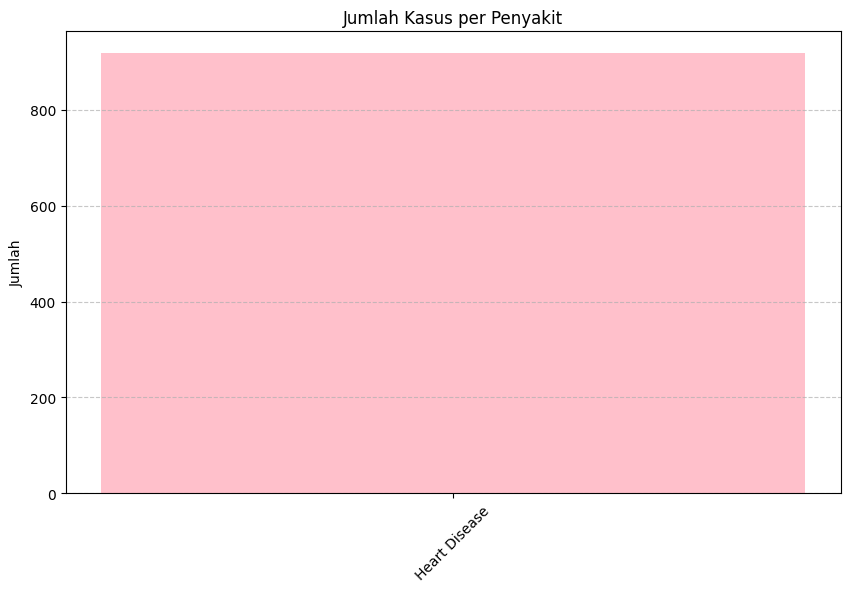

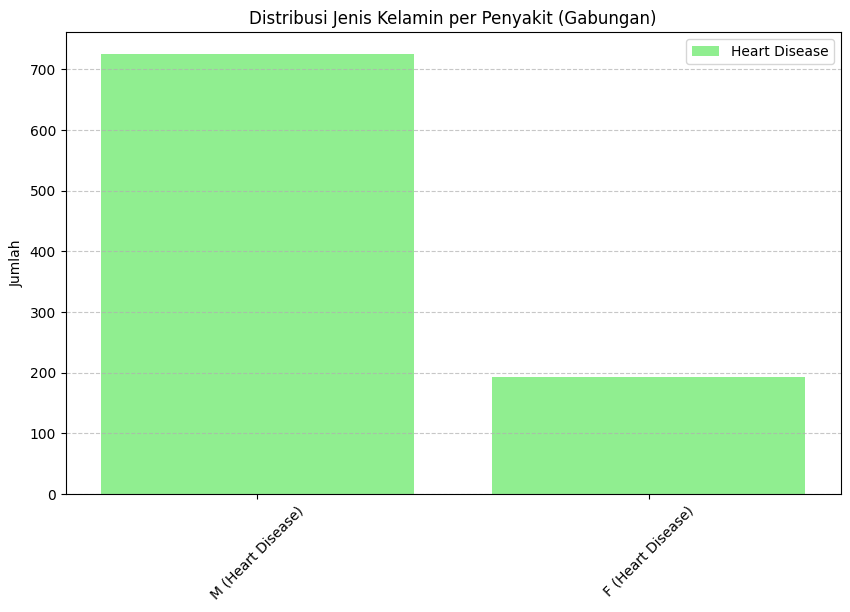

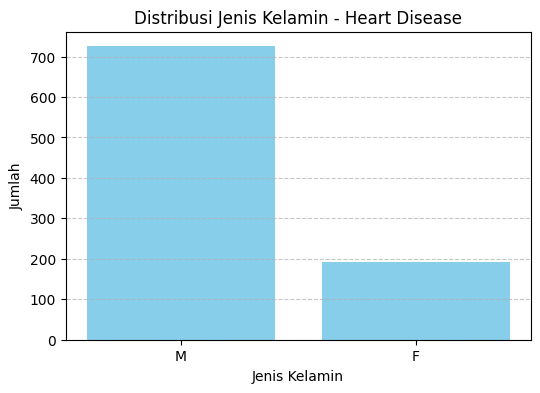

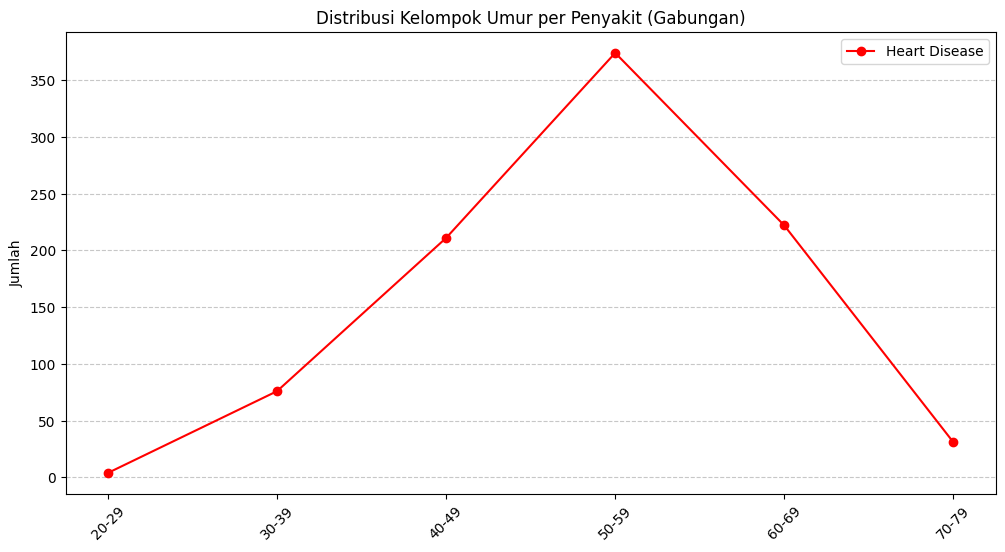

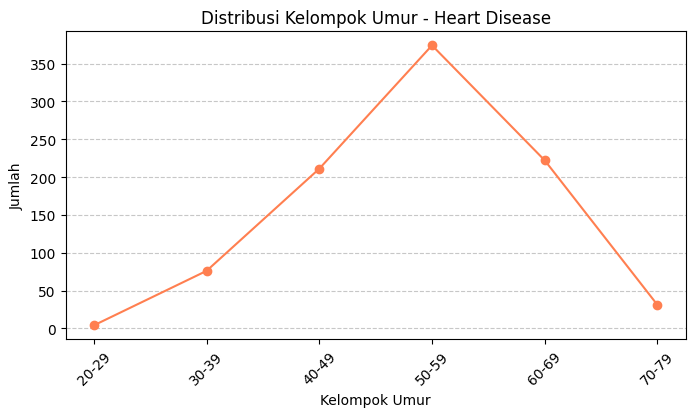

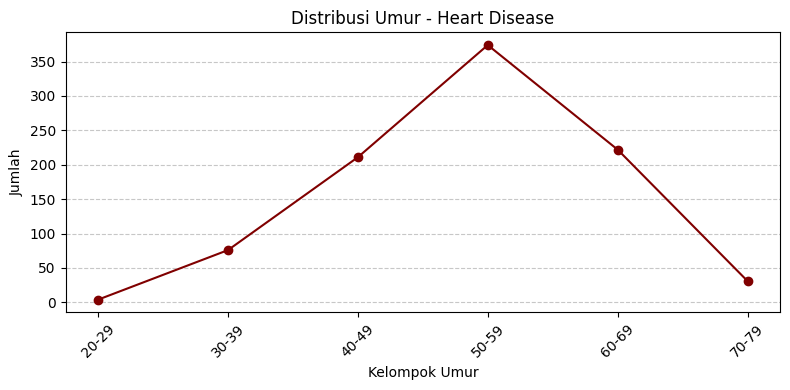

In [65]:
columns_needed = ["Age", "Sex", "JenisPenyakit"]

df_heart = df_heart.withColumn("JenisPenyakit", lit("Heart Disease"))
df_cancer = df_cancer.withColumn("JenisPenyakit", lit("Cancer"))
df_liver = df_liver.withColumn("JenisPenyakit", lit("Liver Disease"))

# Fungsi menyamakan kolom
def add_missing_cols(df, columns):
    existing_cols = df.columns
    missing_cols = [c for c in columns if c not in existing_cols]
    for col_name in missing_cols:
        if col_name == "Age":
            df = df.withColumn(col_name, lit(None).cast(IntegerType()))
        else:
            df = df.withColumn(col_name, lit(None).cast(StringType()))
    return df.select(columns)

# Transformasi DataFrame
df_heart_fixed = add_missing_cols(df_heart, columns_needed)
df_cancer_fixed = add_missing_cols(df_cancer, columns_needed)
df_liver_fixed = add_missing_cols(df_liver, columns_needed)

# Gabungkan
df_all = df_heart_fixed.unionByName(df_cancer_fixed).unionByName(df_liver_fixed)

# Ambil data mentah
raw_data = df_all.select("JenisPenyakit", "Sex", "Age").dropna().rdd.map(lambda row: (row[0], row[1], row[2])).collect()

# Fungsi Analisis
def count_disease(disease_list):
    result = {}
    for d in disease_list:
        key = d[0]
        result[key] = result.get(key, 0) + 1
    return result

def count_sex(data_list):
    result = {}
    for d in data_list:
        key = (d[0], d[1])
        result[key] = result.get(key, 0) + 1
    return result

def count_age_group(data_list):
    result = {}
    for d in data_list:
        try:
            age = int(float(d[2]))
        except:
            continue
        age_group = f"{(age//10)*10}-{(age//10)*10+9}"
        key = (d[0], age_group)
        result[key] = result.get(key, 0) + 1
    return result

def merge_dicts(dicts):
    merged = {}
    for d in dicts:
        for k, v in d.items():
            merged[k] = merged.get(k, 0) + v
    return merged

def urut_age_group(df):
    df['GroupStart'] = df['AgeGroup'].str.extract(r'(\d+)', expand=False).astype(int)
    return df.sort_values('GroupStart').drop(columns=['GroupStart'])

# Multiprocessing
chunks = np.array_split(raw_data, mp.cpu_count())

with mp.Pool() as pool:
    counts_disease = pool.map(count_disease, chunks)
    counts_sex = pool.map(count_sex, chunks)
    counts_age = pool.map(count_age_group, chunks)

final_disease = merge_dicts(counts_disease)
final_sex = merge_dicts(counts_sex)
final_age = merge_dicts(counts_age)

# Konversi ke DataFrame Pandas
df_disease = pd.DataFrame(list(final_disease.items()), columns=["JenisPenyakit", "Jumlah"])
df_sex = pd.DataFrame([(k[0], k[1], v) for k,v in final_sex.items()], columns=["JenisPenyakit", "Sex", "Jumlah"])
df_age = pd.DataFrame([(k[0], k[1], v) for k,v in final_age.items()], columns=["JenisPenyakit", "AgeGroup", "Jumlah"])

# Plot Jumlah Kasus
plt.figure(figsize=(10,6))
plt.bar(df_disease["JenisPenyakit"], df_disease["Jumlah"], color='pink')
plt.title("Jumlah Kasus per Penyakit")
plt.xticks(rotation=45)
plt.ylabel("Jumlah")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Plot Gabungan Jenis Kelamin
plt.figure(figsize=(10,6))
for penyakit in df_sex["JenisPenyakit"].unique():
    subset = df_sex[df_sex["JenisPenyakit"] == penyakit]
    plt.bar(subset["Sex"] + " (" + penyakit + ")", subset["Jumlah"], label=penyakit, color='lightgreen')
plt.title("Distribusi Jenis Kelamin per Penyakit (Gabungan)")
plt.xticks(rotation=45)
plt.ylabel("Jumlah")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Plot Jenis Kelamin per Penyakit (Terpisah)
for penyakit in df_sex["JenisPenyakit"].unique():
    subset = df_sex[df_sex["JenisPenyakit"] == penyakit]
    plt.figure(figsize=(6,4))
    plt.bar(subset["Sex"], subset["Jumlah"], color='skyblue')
    plt.title(f"Distribusi Jenis Kelamin - {penyakit}")
    plt.xlabel("Jenis Kelamin")
    plt.ylabel("Jumlah")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# Plot Gabungan Kelompok Umur
plt.figure(figsize=(12,6))
for penyakit in df_age["JenisPenyakit"].unique():
    subset = df_age[df_age["JenisPenyakit"] == penyakit].sort_values("AgeGroup")
    plt.plot(subset["AgeGroup"], subset["Jumlah"], marker='o', label=penyakit, color='red')
plt.title("Distribusi Kelompok Umur per Penyakit (Gabungan)")
plt.xticks(rotation=45)
plt.ylabel("Jumlah")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Plot Umur per Penyakit (Terpisah)
for penyakit in df_age["JenisPenyakit"].unique():
    subset = df_age[df_age["JenisPenyakit"] == penyakit].sort_values("AgeGroup")
    plt.figure(figsize=(8,4))
    plt.plot(subset["AgeGroup"], subset["Jumlah"], marker='o', linestyle='-', color='coral')
    plt.title(f"Distribusi Kelompok Umur - {penyakit}")
    plt.xlabel("Kelompok Umur")
    plt.ylabel("Jumlah")
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# Warna yang valid ya, sayang
color_map = {
    "Heart Disease": "maroon",
    "Cancer": "orchid",
    "Liver Disease": "gold"
}

# Plot terpisah untuk setiap penyakit
for penyakit in df_age["JenisPenyakit"].unique():
    subset = df_age[df_age["JenisPenyakit"] == penyakit]
    subset = urut_age_group(subset)

    plt.figure(figsize=(8, 4))
    plt.plot(subset["AgeGroup"], subset["Jumlah"], marker='o', linestyle='-', color=color_map.get(penyakit, 'brown'))
    plt.title(f"Distribusi Umur - {penyakit}")
    plt.xlabel("Kelompok Umur")
    plt.ylabel("Jumlah")
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


In [72]:
import psutil
print(f"Jumlah CPU tersedia: {psutil.cpu_count(logical=True)}")
print(f"Penggunaan CPU saat ini: {psutil.cpu_percent()}%")


Jumlah CPU tersedia: 2
Penggunaan CPU saat ini: 17.5%
